---

# Image Captioning with LSTM and RNN/GRU Models

## Introduction

- Image captioning is a task in which computer vision technology is used for generating natural language descriptions of the contents of an image. The ability to generate accurate captions for images requires a model that can understand the visual content and be able to convert it to textual description. This process bridges the gap between vision and language, enabling machines to interpret and describe images in a way that is understandable to humans.

- For this project, we aim to develop an image captioning system that uses a combination of **LSTM** and also a combination of **GRU** (Gated Recurrent Unit) + **RNN** (Recurrent Neural Network) with **Attention** mechanisms to generate accurate and contextually relevant captions for images.
- The project approach involves using **ResNet50** as the feature extractor for images and combining it with a sequence-to-sequence model that leverages LSTM, GRU+RNN+attention layers to generate captions.


### The Key Components of the Image Captioning System:
- **Image Feature Extraction**: We use **ResNet50**, a deep convolutional neural network, pre-trained on large-scale image datasets (such as ImageNet), to extract meaningful features from images. These features are used as the input to the captioning model.
  
- **Caption Generation**: The caption generation model is based on sequence-to-sequence learning, where the model learns to map image features (input sequence) to a sequence of words (output captions).
- We enhance the model with **LSTM**,and also **GRU**+**RNN** layers, which are designed to capture the temporal dependencies of the generated captions. Also for GRU/RNN models, an **Attention** mechanism is added to enable the model to focus on specific parts of the image when generating each word of the caption.

## What and How We Are Solving It

- The main probelm being able to accurately generate captions that are not only syntactically correct but also semantically relevant to the content of the image. The caption should accurately describe the objects in an image, their relationships and actions/context in the image. To come up with these model, we will use;
    1. **Using ResNet50 for Feature Extraction**: Use ResNet50 through taking advantage of a pre-trained model that has learned rich visual features from a large dataset. Features extracted are then used as inputs to our caption generation model.
    2. **Sequence-to-Sequence Learning with LSTM, GRU and RNN**: The LSTM, GRU and RNN layers allow the model to capture the sequential dependencies between words in the caption, ensuring the generated text is coherent and fluent.


## How the Data is Created

The data for this project consists of **images and their corresponding captions** which are provided by **Flickr 8K** and can be accessed on this link https://www.kaggle.com/datasets/adityajn105/flickr8k.

The process of creating this dataset involves several key steps:

1. **Image Feature Extraction**:
   - We use **ResNet50**, a pre-trained deep CNN model, to extract features from the images. ResNet50 is specifically chosen for its ability to capture complex visual patterns through its deep layers. These feature vectors are then used as input to the caption generation model.

2. **Caption Preprocessing**:
   - Each image has a corresponding caption, which is processed and tokenized into individual words. We create a vocabulary of unique words present in the dataset.
   - The captions are padded or truncated to a fixed length (`max_len`), ensuring consistent input dimensions for the model.

3. **Training the Model**:
   - During training, the extracted image features are used as the initial input to the model, and the sequence of words is generated word by word.
   - The model learns to predict the next word in the sequence based on the previous words and the image features, optimizing its parameters to generate high-quality captions.

4. **Validation and Testing**:
   - The model is evaluated using metrics like **accuracy**, 

### Load modules 

In [2]:
import os
import re
import pickle 
import numpy as np
import pandas as pd
import random
from tqdm.notebook import tqdm 
import glob
import cv2

# plot
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# for feature extraction, we use mobinet transformer model.
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# for loading ddata and also modeling using tf
from tensorflow.keras.layers import (
    Input , Dense , LSTM, SimpleRNN, GRU, Attention , Embedding , Dropout,
    RepeatVector, Concatenate, TimeDistributed
)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# metrics
from tensorflow.keras.metrics import Precision,AUC



import warnings
warnings.filterwarnings("ignore")


In [3]:
# checking the directories
os.listdir("/kaggle/input/flickr8k")

['captions.txt', 'Images']

In [4]:
# get the base directory for the project
BASE_DIR = "/kaggle/input/flickr8k"

In [5]:
# check the number of images
images_paths = glob.glob(f"{BASE_DIR}/Images/*.jpg")

print(f"There are {len(images_paths)} images on flickr8k data")

There are 8091 images on flickr8k data


In [6]:
# check sample captions
with open(f"{BASE_DIR}/captions.txt", "r") as captions_obj:
    captions_data = captions_obj.readlines()

captions_data[1:6]

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n']

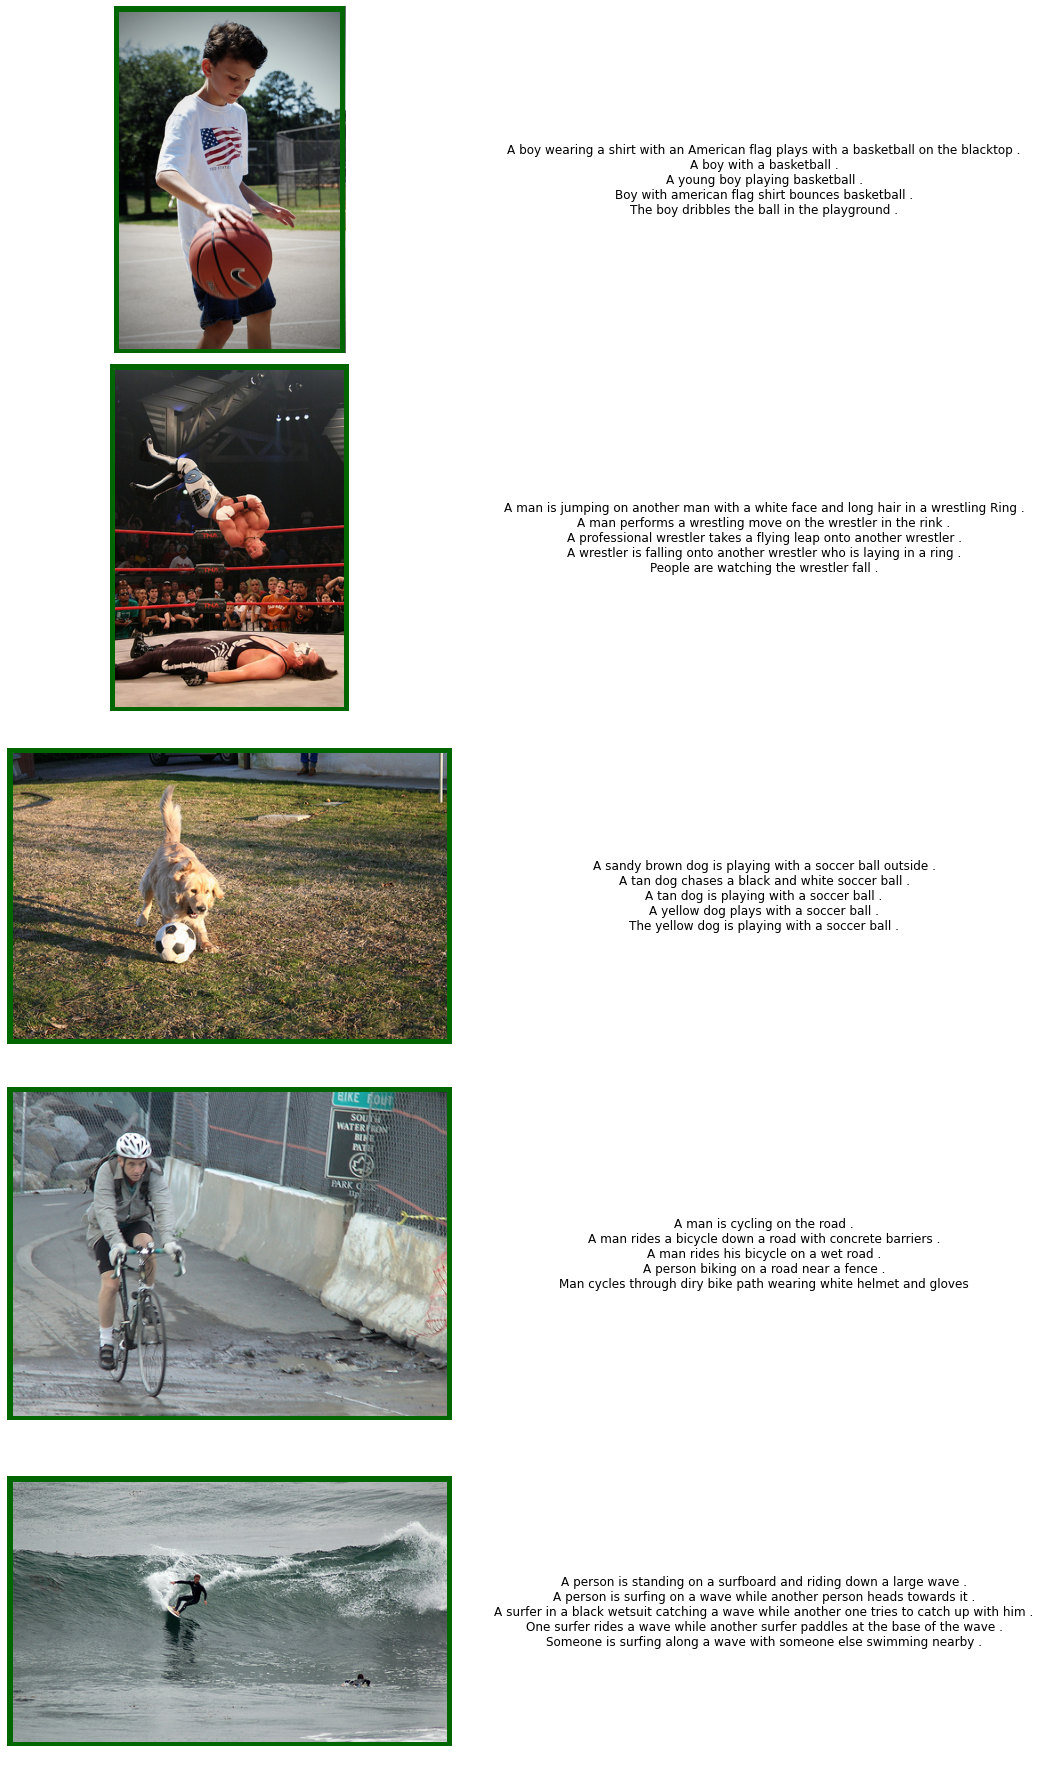

In [7]:
# function to load and display results
def display_random_images_with_captions(captions_file, images_folder, num_images=5):
    """
    Displays random images with their corresponding captions.
    """
    # load captions into a dictionary
    with open(captions_file, 'r') as file:
        lines = file.readlines()

    captions_dict = {}
    for line in lines:
        image_name, caption = line.strip().split(',', 1)
        if image_name not in captions_dict:
            captions_dict[image_name] = []
        captions_dict[image_name].append(caption)

    # get images randomly
    selected_images = random.sample(list(captions_dict.keys()), num_images)

    #plot them with their captions
    fig, axes = plt.subplots(num_images, 2, figsize=(15, num_images * 5))

    for idx, image_name in enumerate(selected_images):
        image_path = f'{images_folder}/{image_name}'
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # display the image
        axes[idx, 0].imshow(image)
        axes[idx, 0].axis('off')

        # add a border around the image
        rect = patches.Rectangle(
            (0, 0), image.shape[1], image.shape[0], 
            linewidth=10, edgecolor='#006600', facecolor='none'
        )
        axes[idx, 0].add_patch(rect)

        # show the captions
        captions = captions_dict[image_name]
        captions_text = "\n".join(captions)
        axes[idx, 1].text(
            0.5, 0.5, captions_text, ha='center', va='center', wrap=True, fontsize=12
        )
        axes[idx, 1].axis('off')

    plt.tight_layout()
    plt.show()


captions_file = f'{BASE_DIR}/captions.txt'
images_folder = f'{BASE_DIR}/Images'
display_random_images_with_captions(captions_file, images_folder, num_images=5)


### Extract Image Features
- In this we need to get the images features.
- The images will be loaded and features created.

- To generate the features, we utilize **transfer learning** to extract features from the images.
- A pre-trained `Resnet50` model, fine-tuned on the ImageNet dataset, is used as the feature extractor.
- The images are loaded and resized to match the input dimensions required by resnet50. In this case, the model would not be a fully connected one as we only need to exract image features. We will not also include all layers for faster extraction.
- Features are extracted from the penultimate layer (global average pooling output) to represent each image as a compact feature vector.
- These extracted features will serve as input to the transformer-based image captioning model.



In [8]:
# load the resnet model for extraction
resnet_model = ResNet50(include_top=True)

102981632/102967424 [==============================] - 1s 0us/step


In [9]:
print(f"Resnet model has {len(resnet_model.layers)} layers")

Resnet model has 177 layers


In [10]:
resnet_model.layers[-2]

In [11]:
# get the layers to use for feature extraction
# for we are getting the GlobalAveragePooling2D as the last layer
output_layer = resnet_model.layers[-2].output
resnet_extractor = Model(inputs=resnet_model.input,outputs=output_layer)


print(f"New number of Layers are {len(resnet_extractor.layers)}")

New number of Layers are 176


In [12]:

# create a dict to  store image features
img_features = {}
count = 0

# iterate through all images path and extract its features
for img_path in tqdm(images_paths, desc="Extracting Features"):
    # read and preprocess the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # ResNet needs input images of size (224, 224, 3)
    img = img.reshape(1, 224, 224, 3)  
    # extract features using the pre-trained model
    # we also flatten the results to 1D array
    features = resnet_extractor.predict(img).reshape(2048,) 
    
    # get image name from the path to use it as key on data dictionary
    img_name = img_path.split('/')[-1]
    img_features[img_name] = features  
    count += 1

    # lets start with a few to avoid memory issues 
    if count == 4000:
        break
    if count % 500 == 0:
        print(f"Processed {count} images.")


print(f"Processed {len(img_features)} features already....")

Extracting Features:   0%|          | 0/8091 [00:00<?, ?it/s]

Processed 500 images.
Processed 1000 images.
Processed 1500 images.
Processed 2000 images.
Processed 2500 images.
Processed 3000 images.
Processed 3500 images.
Processed 4000 features already....


In [13]:
pd.DataFrame(img_features)

3226254560_2f8ac147ea.jpg  214543992_ce6c0d9f9b.jpg  \
0                      0.628256                  0.462206   
1                      0.784914                  0.291619   
2                      0.566702                  0.068929   
3                      0.400272                  0.242510   
4                      0.489651                  0.903063   
...                         ...                       ...   
2043                   0.000000                  0.000000   
2044                   0.095160                  0.521409   
2045                   0.891392                  0.573068   
2046                   0.000046                  0.000000   
2047                   0.000000                  0.287854   

      2366643786_9c9a830db8.jpg  3368819708_0bfa0808f8.jpg  \
0                      0.889709                   0.493052   
1                      0.164984                   0.648831   
2                      0.038307                   0.039441   
3                      1.286187                   0.864937   
4                      0.286225                   0.027097   
...                         ...                        ...   
2043                   0.855795                   0.072925   
2044                   0.016603                   0.004082   
2045                   0.270472                   0.495287   
2046                   0.678553                   0.048743   
2047                   0.152417                   0.000000   

      2190227737_6e0bde2623.jpg  2752809449_632cd991b3.jpg  \
0                      0.827950                   0.241903   
1                      0.000000                   0.354914   
2                      0.984368                   0.031300   
3                      0.000000                   3.079931   
4                      0.651485                   0.026881   
...                         ...                        ...   
2043                   1.473816                   0.141198   
2044                   0.354321                   1.114501   
2045                   0.126652                   0.000000   
2046                   0.509681                   0.128231   
2047                   2.533145                   0.135415   

      3097776588_312932e438.jpg  1206506157_c7956accd5.jpg  \
0                      0.585601                   1.445666   
1                      0.056711                   1.818805   
2                      0.897878                   0.177850   
3                      0.202745                   0.000000   
4                      0.226945                   0.036244   
...                         ...                        ...   
2043                   0.227614                   0.085708   
2044                   0.075380                   0.000000   
2045                   2.385899                   0.051166   
2046                   0.032806                   0.000000   
2047                   0.095018                   0.985355   

      1319634306_816f21677f.jpg  2465218087_fca77998c6.jpg  ...  \
0                      1.293468                   0.355679  ...   
1                      1.202497                   0.380740  ...   
2                      0.729069                   0.013259  ...   
3                      0.029511                   1.456639  ...   
4                      0.097015                   0.002590  ...   
...                         ...                        ...  ...   
2043                   0.241287                   0.465535  ...   
2044                   0.016082                   0.011540  ...   
2045                   0.000000                   0.064613  ...   
2046                   0.755533                   0.026692  ...   
2047                   0.158195                   1.044033  ...   

      2618538137_44fffe10c4.jpg  1057089366_ca83da0877.jpg  \
0                      0.613421                   0.345884   
1                      2.621401                   0.027309   
2                      1.295742                

- The extracted features are going to be saved as csv for easier access


In [14]:
pd.DataFrame(img_features).to_csv("extracted_features.csv", index=False)

### Loading the Captions Data
- The captions are stored in a txt file where for each line, there are two items i.e
    - Image (contains image path)
    - Caption, which is the text in which the image represents.

- To read above, we will use pandas to get the dataframe with the two columns. Since then we are supposed to access the caption by image name/imageid, we will store the captions as a dictionary with image path being the key and the caption as the value. Here is the working.

In [15]:
# read the images
def load_captions_as_dict(captions_file):
    """
    Load image captions into a dictionary with the image name as the key 
    and a list of captions as the value.
    """
    # read the captions file into a pandas DataFrame
    captions_df = pd.read_csv(captions_file)
    # group captions by image and convert to a dictionary
    captions_dict = captions_df.groupby('image')['caption'].apply(list).to_dict()

    #we just return for the one in which we have loaded the images
    available_captions = {
        key: val for key, val in captions_dict.items() if key in img_features
    }
    
    return available_captions

captions_file = f"{BASE_DIR}/captions.txt"
captions_dict = load_captions_as_dict(captions_file)


In [16]:
# check the size of caption
len(captions_dict)

4000

In [17]:
def text_preprocess(text):
    """
    Preprocess a single caption by converting to lowercase and adding special tokens.
    """
    # convert text to lowercase and add start and end tokens
    modified_text = text.lower()

    # Replace multiple dots with a single dot and remove dots if they occur more than once
    modified_text = re.sub(r'\.+', '.', modified_text)
    modified_text = re.sub(r'\.', '', modified_text)
    modified_text = re.sub(r'\.\s+\.', '', modified_text)
    
    # Replace dots with a space if there is no space between the words
    modified_text = re.sub(r'\.(\S)', r' \1', modified_text)
    # Remove extra spaces
    modified_text = re.sub(r'\s+', ' ', modified_text.strip())
    modified_text = modified_text.replace('[^A-Za-z]', '')
    modified_text = ''.join(modified_text)

    

    modified_text = 'startofseq ' + modified_text + ' endofseq'
    return modified_text

def preprocess_captions(captions_dict):
    """
    Preprocess all captions in the dictionary by applying the `text_preprocess` function.
    """
    caption_dict_copy = captions_dict.copy()
    for key, captions in caption_dict_copy.items():
        # Process each caption in the list
        caption_dict_copy[key] = text_preprocess(" ".join(captions))
    
    return caption_dict_copy

# use the functions
preprocessed_captions_dict = preprocess_captions(captions_dict)


In [18]:
preprocessed_captions_dict.get("1000268201_693b08cb0e.jpg")

In [19]:
def build_vocabulary(captions_dict):
    """
    Build a vocabulary from the captions dictionary.

    """
    count_words = {}
    cnt = 1 #we start from 1 since 0 is a padding option
    for captions in captions_dict.values():
        for word in captions.split():  
            if word not in count_words:
                count_words[word] = cnt 
                cnt += 1

    return count_words

vocabulary = build_vocabulary(preprocessed_captions_dict)

# check the vocabulary size:
print(f"Vocabulary size: {len(vocabulary)}")


Vocabulary size: 6483


In [20]:
def encode_captions(captions_dict, vocabulary):
    """
    Encode the captions into integer sequences using the vocabulary.
    """
    #track the maximum caption length
    max_len = 0 
    caption_results ={}

    for i, (key, captions) in enumerate(captions_dict.items()):
        encoded = [vocabulary[word] for word in captions.split()] 
        caption_results[key] = encoded
        max_len = max(max_len, len(encoded)) 
    return caption_results, max_len


encoded_captions_dict, max_caption_length = encode_captions(preprocessed_captions_dict, vocabulary)

print(f"Maximum caption length: {max_caption_length}")


Maximum caption length: 101


In [22]:
# generates results
def generator(img_features,captions, max_caption_length, vocab_size):
    """
    Generator function for training: yields image features, input sequences, and output sequences.
    """
    n_samples = 0
    X = []
    y_input = []
    y_output = []
    
    for key, val in captions.items(): 
        for i in range(1,len(val)):
            if key in img_features:
                X.append(img_features[key]) 
                input_seq = [val[:i]] # Previously generated text to be used as input to predict the next word 
                output_seq = val[i] # The next word to be predicted as output
                # Padding encoded text sequences to the maximum length
                input_seq = pad_sequences(input_seq,maxlen=max_caption_length,padding='post',truncating='post')[0] 
                # One Hot encoding the output sequence with vocabulary size as the total no. of classes
                output_seq = to_categorical([output_seq],num_classes=vocab_size+1)[0]
                y_input.append(input_seq)
                y_output.append(output_seq)
    return X, y_input, y_output

In [23]:
X, y_in, y_out = generator(img_features,encoded_captions_dict, max_caption_length, len(vocabulary))

In [24]:
# get the output shape (should be the same for X, y_in, y_out)
print(len(X), len(y_in), len(y_out)) 

222082 222082 222082


In [25]:
# convert to numpy arrays
X = np.array(X)
y_in = np.array(y_in, dtype='float32')
y_out = np.array(y_out, dtype='float32')

In [26]:
# recheck the sizes
X.shape, y_in.shape, y_out.shape

((222082, 2048), (222082, 101), (222082, 6484))

In [27]:
# define lstm model
def create_LSTM_captioning_model(vocab_size, embedding_len, max_len):
    """
    Create and compile the image captioning model.
    """
    # for image feature extraction (Image model)
    img_model = Sequential(name='Image_Feature_Extraction_Model')
    img_model.add(Dense(embedding_len, input_shape=(2048,), activation='relu', name='Dense_Layer'))
    img_model.add(RepeatVector(max_len, name='Repeat_Vector')) 
    
    # for generating captions from image features (Caption model)
    captions_model = Sequential(name='Caption_Generation_Model')
    captions_model.add(Embedding(input_dim=vocab_size + 1, output_dim=embedding_len, input_length=max_len))
    captions_model.add(LSTM(256, return_sequences=True))
    captions_model.add(TimeDistributed(Dense(embedding_len)))

    # combine the outputs of image and caption models
    concat_output = Concatenate(name='Concatenate_Layer')([img_model.output, captions_model.output])

    # 1st LSTM Layer
    output = LSTM(units=128, return_sequences=True, name='LSTM_Layer_2')(concat_output)

    # 2nd LSTM Layer
    output = LSTM(units=512, return_sequences=False, name='LSTM_Layer_3')(output)

    # final outout as a probs/ we predict class of words
    output = Dense(units=vocab_size + 1, activation='softmax', name='Output_Layer')(output)

    # combine for the final model
    model = Model(inputs=[img_model.input, captions_model.input], outputs=output, name="Image_Captioning_Model")
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy', AUC()])
    return model




In [28]:
# initalize the model
embedding_len = 128
MAX_LEN = max_caption_length  
BATCH_SIZE = 256
EPOCHS = 30
vocab_size = len(vocabulary) 

lstm_model = create_LSTM_captioning_model(vocab_size, embedding_len, MAX_LEN)

# check model Summary
lstm_model.summary()


Model: "Image_Captioning_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    [(None, 101)]        0                                            
__________________________________________________________________________________________________
Dense_Layer_input (InputLayer)  [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 101, 128)     829952      embedding_input[0][0]            
__________________________________________________________________________________________________
Dense_Layer (Dense)             (None, 128)          262272      Dense_Layer_input[0][0]          
_____________________________________________________________________________

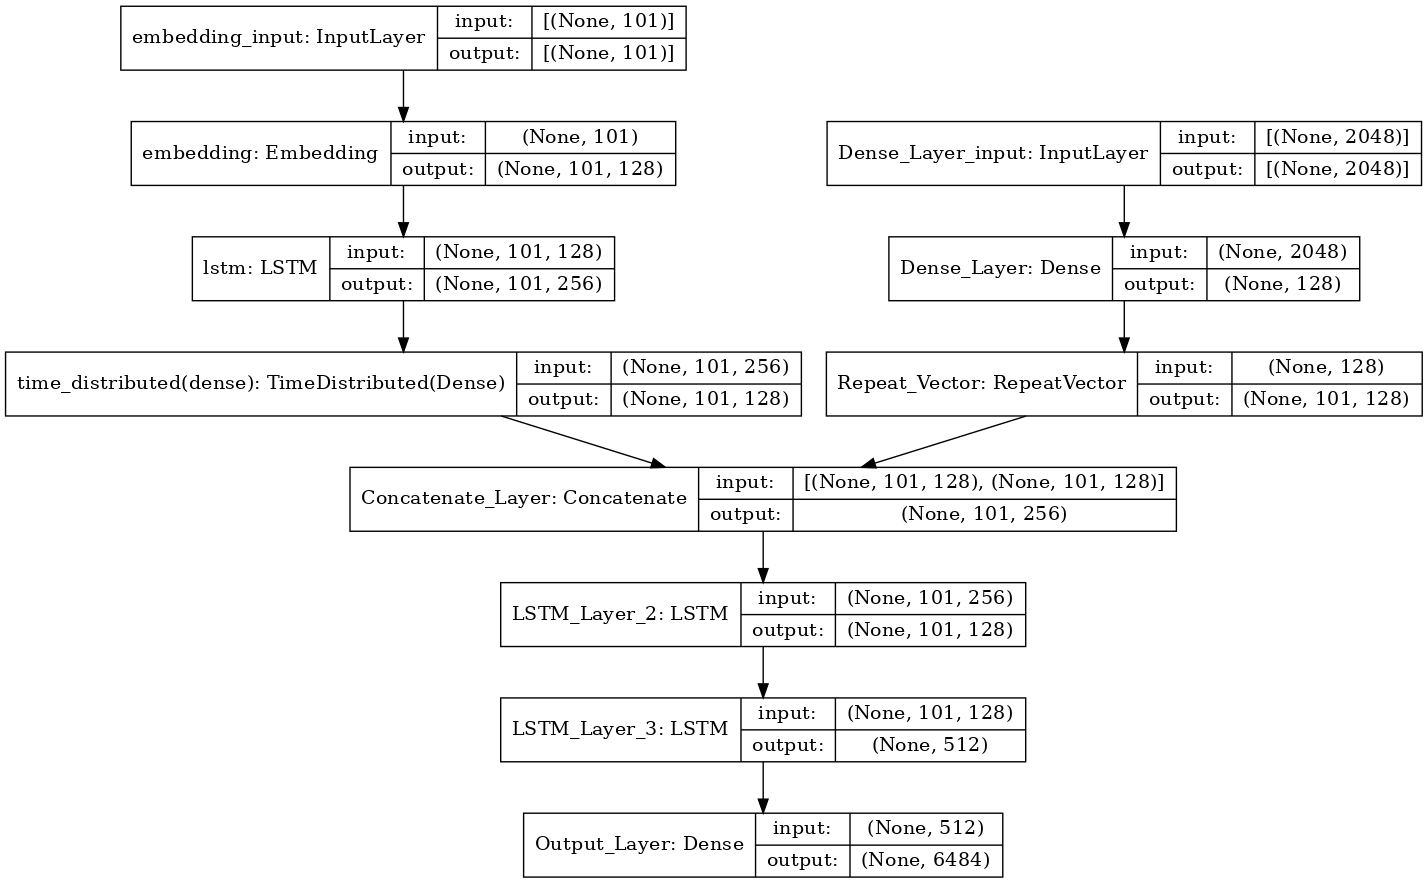

In [29]:
plot_model(lstm_model,'lstm_model.png',show_shapes=True,dpi=100)

In [30]:
# create model's checkpoint callback
checkpoint_callback = ModelCheckpoint('lstm_captioner_model.h5', 
                     monitor='val_accuracy', 
                     verbose=0, 
                     mode='max', 
                     save_best_only=True)


In [31]:
# 
# fit the model with the data and callback
# inputs are (image features and encoded captions)
# outputs are  (next word prediction)
lstm_hist = lstm_model.fit([X, y_in],  
                y_out,      
                batch_size=BATCH_SIZE, 
                callbacks=[checkpoint_callback],  
                validation_split=0.05,
                epochs=EPOCHS
               )  

Epoch 1/30
695/695 [==============================] - 79s 108ms/step - loss: 5.5077 - accuracy: 0.1393 - auc: 0.7613 - val_loss: 5.6366 - val_accuracy: 0.1291 - val_auc: 0.7285
Epoch 2/30
695/695 [==============================] - 73s 104ms/step - loss: 5.3061 - accuracy: 0.1389 - auc: 0.7802 - val_loss: 5.4194 - val_accuracy: 0.1377 - val_auc: 0.7765
Epoch 3/30
695/695 [==============================] - 73s 104ms/step - loss: 5.1919 - accuracy: 0.1384 - auc: 0.7952 - val_loss: 5.3400 - val_accuracy: 0.1368 - val_auc: 0.7857
Epoch 4/30
695/695 [==============================] - 73s 104ms/step - loss: 5.0914 - accuracy: 0.1385 - auc: 0.8050 - val_loss: 5.2866 - val_accuracy: 0.1333 - val_auc: 0.7918
Epoch 5/30
695/695 [==============================] - 73s 104ms/step - loss: 5.0082 - accuracy: 0.1382 - auc: 0.8127 - val_loss: 5.3374 - val_accuracy: 0.1393 - val_auc: 0.7812
Epoch 6/30
695/695 [==============================] - 73s 104ms/step - loss: 4.9293 - accuracy: 0.1386 - auc: 0.818

In [32]:
# lstm_hist.history

Text(0.5, 0.98, 'EVALUATION METRICS FOR LSTM MODEL')

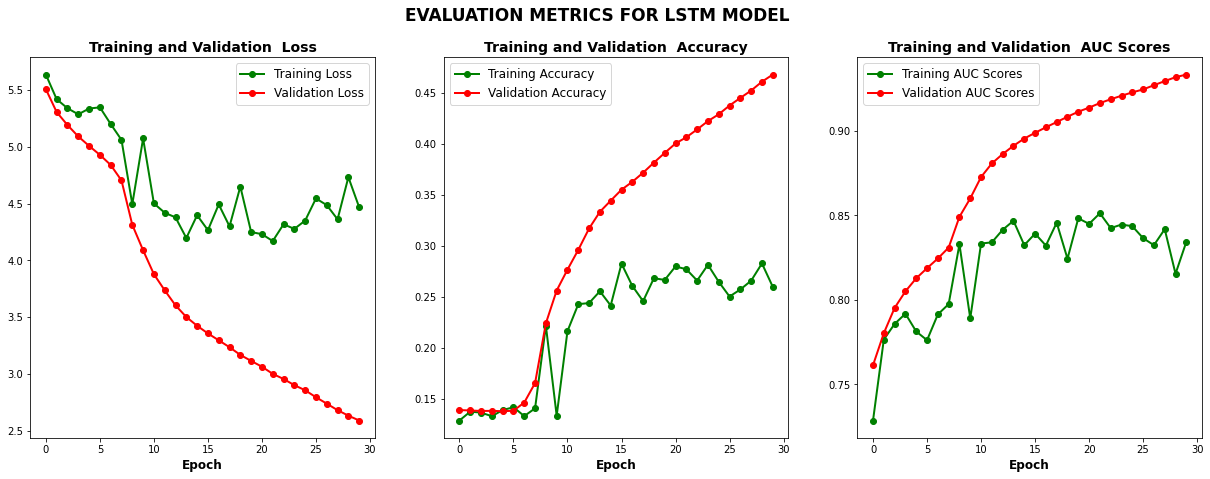

In [33]:
fig, axs = plt.subplots(1,3,figsize=(21,7))

def plot_log(ax, train_value, val_value, label):
    ax.plot(train_value,f'go-', label=f'Training {label}', linewidth=2)
    ax.plot(val_value,f'ro-', label=f'Validation {label}', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_title(f'Training and Validation  {label}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=12)


plot_log(axs[0],lstm_hist.history.get("loss"),lstm_hist.history.get("val_loss"),'Loss')
plot_log(axs[1],lstm_hist.history.get("accuracy"),lstm_hist.history.get("val_accuracy"),'Accuracy')
plot_log(axs[2],lstm_hist.history.get("auc"),lstm_hist.history.get("val_auc"),'AUC Scores')
plt.suptitle("EVALUATION METRICS FOR LSTM MODEL", fontsize=17, fontweight="bold")

### Evaluation on Sample Images
- We randomly select images and use them

In [34]:
# Creating an inverse dictionary with reverse key-value pairs
inverse_vocaburary_dict = {val: key for key,val in vocabulary.items()}

In [35]:
# a ftn to extract image by id and format it for feature extraction
def getImage(image_id, image_files):
    test_img_path = image_files[image_id]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(224,224))
    test_img = np.reshape(test_img,(1,224,224,3))
    return test_img

In [36]:
# images_paths

In [37]:
# a function to use trained model to generat caption

# We limit to about 30 words as max caption words
MAX_CAPTION_LEN = 50
def generate_caption(trained_model, image_paths, image_random_no, max_caption_length=MAX_CAPTION_LEN):
    """
    Generates a caption for a random image by predicting words one by one.
    """
    random_no = image_random_no
    
    # generate the image features
    test_feature = resnet_extractor.predict(getImage(random_no, image_paths)).reshape(1, 2048)
    
    # read the image
    test_img_path = image_paths[random_no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    
    # start pred the prediction text sequence
    pred_text = ['startofseq']
    caption = '' 
    count = 0
    while count < max_caption_length:
        count += 1
        
        # encode the predicted text sequence as numbers
        encoded = [vocabulary[word] for word in pred_text]
        encoded = [encoded]  
        
        # padd the sequence to the maximum length
        encoded = pad_sequences(encoded, maxlen=MAX_LEN, padding='post', truncating='post')
        
        # predict the next word using the model
        model_preds = trained_model.predict([test_feature, encoded])
        pred_idx = np.argmax(model_preds)
        
        # get the predicted word from the inverse dictionary
        sampled_word = inverse_vocaburary_dict[pred_idx]
        # If the end-of-sequence token is predicted, stop
        if sampled_word == 'endofseq':
            break
        
        # add the predicted word to the caption
        caption += ' ' + sampled_word
        pred_text.append(sampled_word)
    
    # show the image and caption
    plt.figure(figsize=(5, 5))
    plt.imshow(test_img)
    plt.xlabel(caption)
    
    return caption

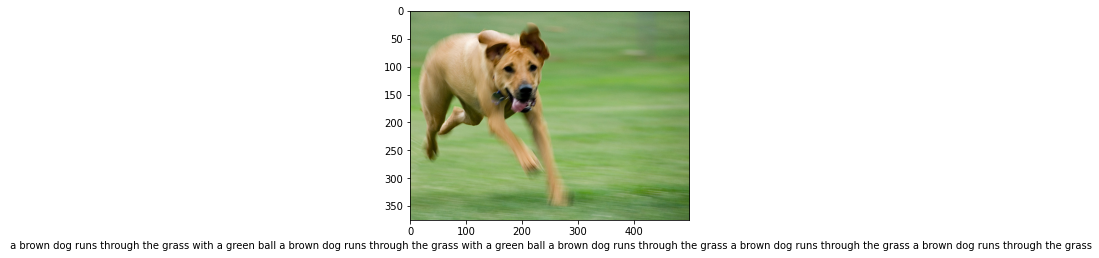

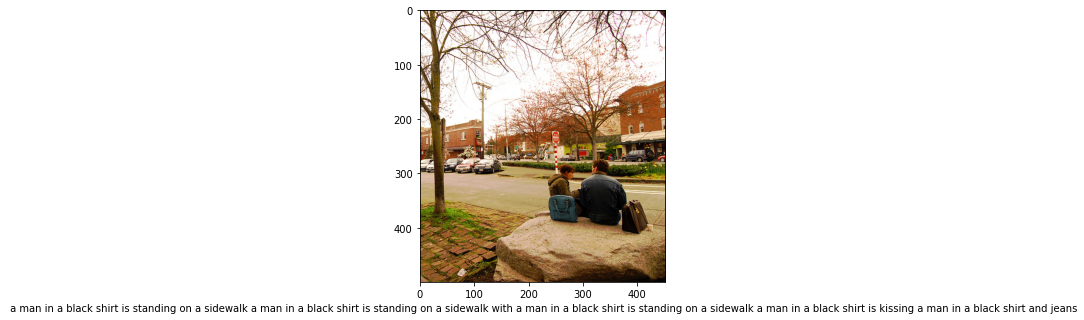

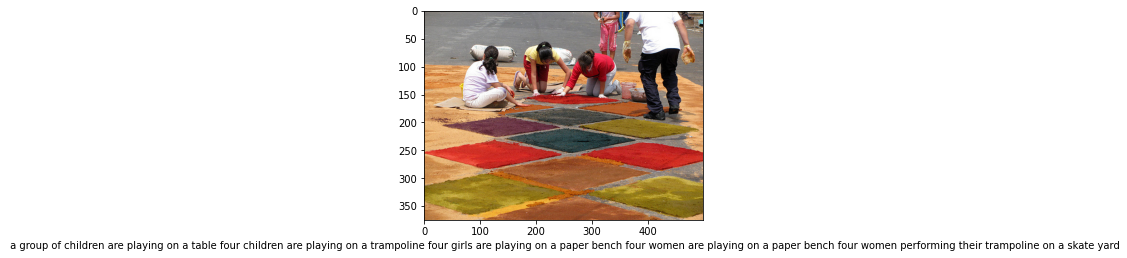

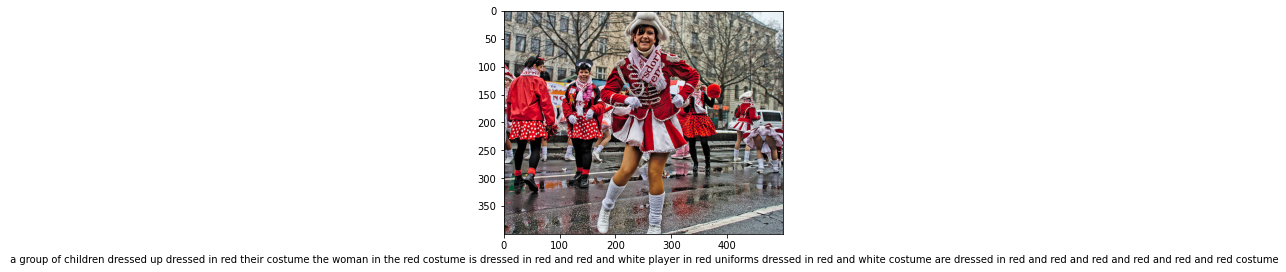

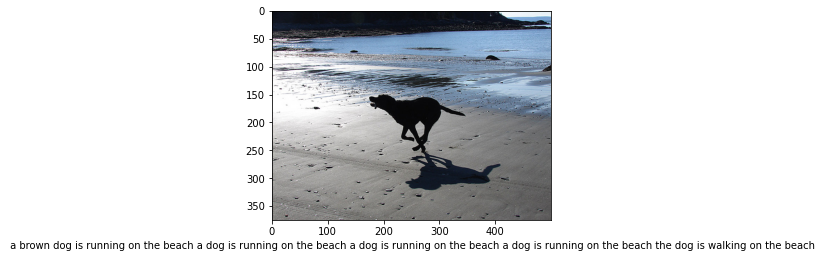

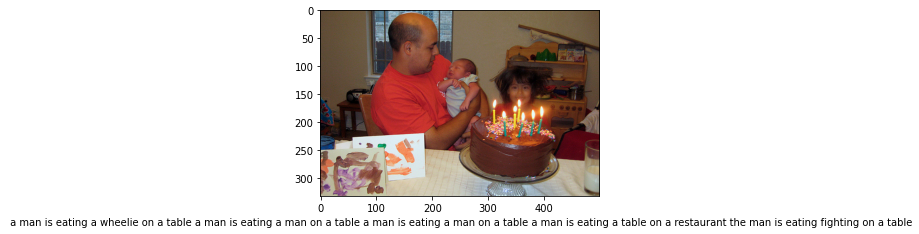

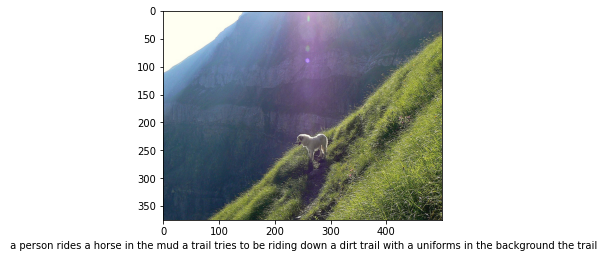

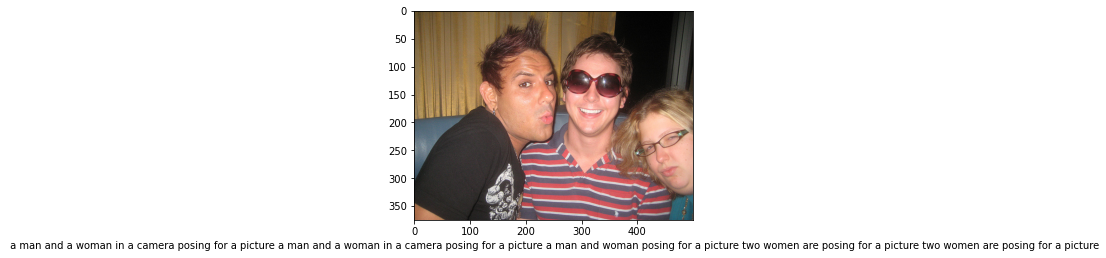

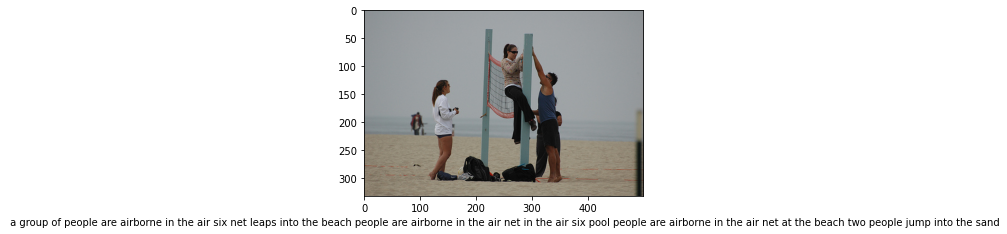

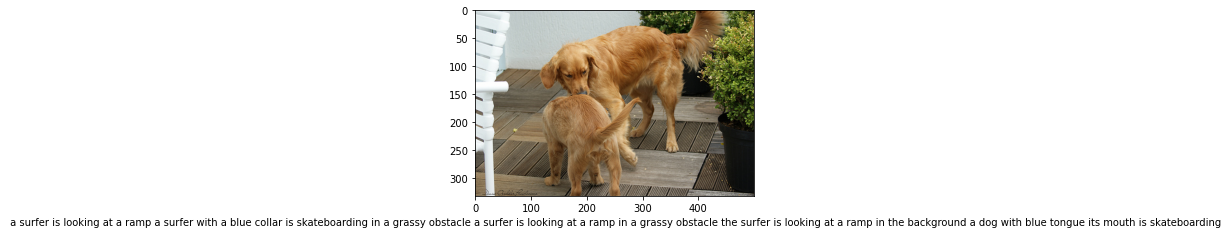

In [38]:
# generate random images
for i in range(10):
    random_image = np.random.randint(0, len(images_paths), (1, 1))[0, 0]
    caption = generate_caption(lstm_model, images_paths, random_image)


### GRU/RNN with some Attention

In [39]:
# create Attention model with GRU + RNN
def create_GRU_RNN_Attention_captioning_model(vocab_size, embedding_len, max_len):
    """
    Create and compile the image captioning model with GRU, RNN, and Attention layers.
    """
    # model for image feature extraction
    img_model = Sequential(name='Image_Feature_Extraction_Model')
    img_model.add(Dense(embedding_len, input_shape=(2048,), activation='relu', name='Dense_Layer'))  
    img_model.add(RepeatVector(max_len, name='Repeat_Vector'))  
    
    # model for generating captions from image features 
    captions_model = Sequential(name='Caption_Generation_Model')
    captions_model.add(Embedding(input_dim=vocab_size + 1, output_dim=embedding_len, input_length=max_len))
    captions_model.add(TimeDistributed(Dense(embedding_len)))

    # GRU Layer
    gru_output = GRU(256, return_sequences=True, name='GRU_Layer')(captions_model.output)

    # RNN Layer
    rnn_output = SimpleRNN(256, return_sequences=True, name='RNN_Layer')(captions_model.output)

    # combine the GRU and RNN outputs
    concat_output = Concatenate(name='Concatenate_Layer')([gru_output, rnn_output])

    # Attention Layer
    attention_output = Attention(use_scale=True)([concat_output, concat_output])  # Self-attention (query, value, key are the same)

    # 1st GRU Layer after Attention
    output = GRU(units=128, return_sequences=True, name='GRU_Layer_2')(attention_output)

    # 2nd GRU Layer after Attention
    output = GRU(units=512, return_sequences=False, name='GRU_Layer_3')(output)

    # for output, we use softmax since iut is class predictions/words
    output = Dense(units=vocab_size + 1, activation='softmax', name='Output_Layer')(output)

    # merge the model
    model = Model(inputs=[img_model.input, captions_model.input], outputs=output, name="Image_Captioning_Model")
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy', AUC()])
    return model


In [40]:
# create the model
rnn_model = create_GRU_RNN_Attention_captioning_model(vocab_size, embedding_len, MAX_LEN)

# vocab_size, embedding_len, MAX_LEN

rnn_model.summary()

Model: "Image_Captioning_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  [(None, 101)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 101, 128)     829952      embedding_1_input[0][0]          
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 101, 128)     16512       embedding_1[0][0]                
__________________________________________________________________________________________________
GRU_Layer (GRU)                 (None, 101, 256)     296448      time_distributed_1[0][0]         
_____________________________________________________________________________

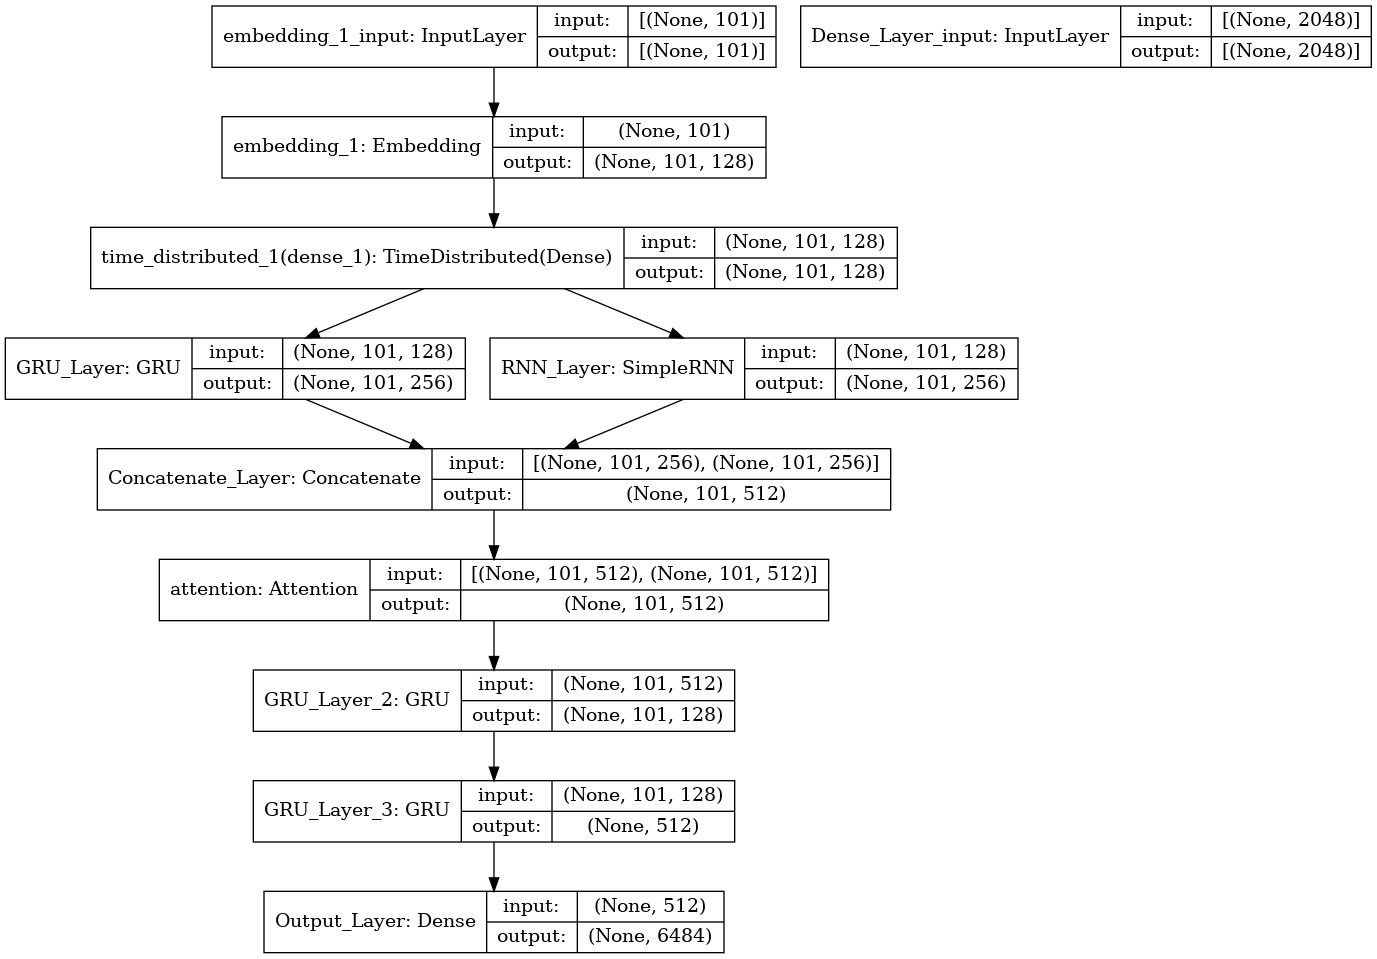

In [41]:
plot_model(rnn_model,'rnn_model.png',show_shapes=True)

In [42]:

# checkpoint for rnn
rnn_checkpoint = ModelCheckpoint('attention_image_caption_generator.h5', 
                                      monitor='val_accuracy', 
                                      verbose=1, 
                                      mode='max', 
                                      save_best_only=True)


In [43]:
y_out.shape

(222082, 6484)

In [44]:
# train the model
rnn_history = rnn_model.fit([X, y_in], 
                y_out,
                batch_size=BATCH_SIZE,
                validation_split=0.05,
                epochs=EPOCHS, 
                callbacks=[rnn_checkpoint])


Epoch 1/30
695/695 [==============================] - 106s 147ms/step - loss: 5.6245 - accuracy: 0.1393 - auc_1: 0.7480 - val_loss: 5.7255 - val_accuracy: 0.1285 - val_auc_1: 0.7271

Epoch 00001: val_accuracy improved from -inf to 0.12846, saving model to attention_image_caption_generator.h5
Epoch 2/30
695/695 [==============================] - 100s 143ms/step - loss: 4.8838 - accuracy: 0.1888 - auc_1: 0.8000 - val_loss: 4.6601 - val_accuracy: 0.2061 - val_auc_1: 0.8214

Epoch 00002: val_accuracy improved from 0.12846 to 0.20607, saving model to attention_image_caption_generator.h5
Epoch 3/30
695/695 [==============================] - 99s 143ms/step - loss: 4.1326 - accuracy: 0.2653 - auc_1: 0.8472 - val_loss: 4.2278 - val_accuracy: 0.2678 - val_auc_1: 0.8365

Epoch 00003: val_accuracy improved from 0.20607 to 0.26785, saving model to attention_image_caption_generator.h5
Epoch 4/30
695/695 [==============================] - 100s 143ms/step - loss: 3.8672 - accuracy: 0.2947 - auc_1: 0.8

Text(0.5, 0.98, 'EVALUATION METRICS FOR RNN/GRU MODEL')

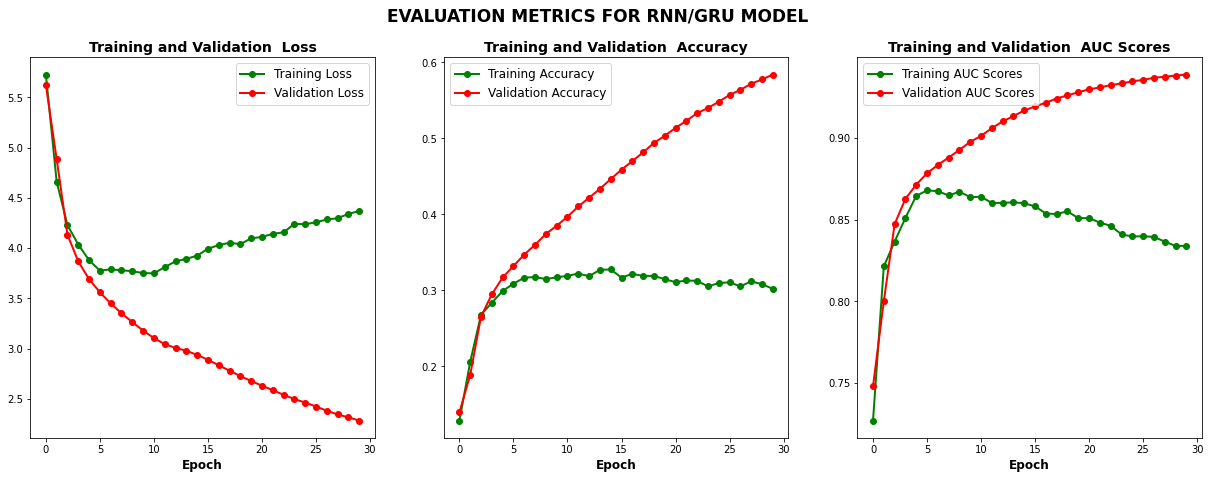

In [46]:
fig, axs = plt.subplots(1,3,figsize=(21,7))
plot_log(axs[0],rnn_history.history.get("loss"),rnn_history.history.get("val_loss"),'Loss')
plot_log(axs[1],rnn_history.history.get("accuracy"),rnn_history.history.get("val_accuracy"),'Accuracy')
plot_log(axs[2],rnn_history.history.get("auc_1"),rnn_history.history.get("val_auc_1"),'AUC Scores')
plt.suptitle("EVALUATION METRICS FOR RNN/GRU MODEL", fontsize=17, fontweight="bold")

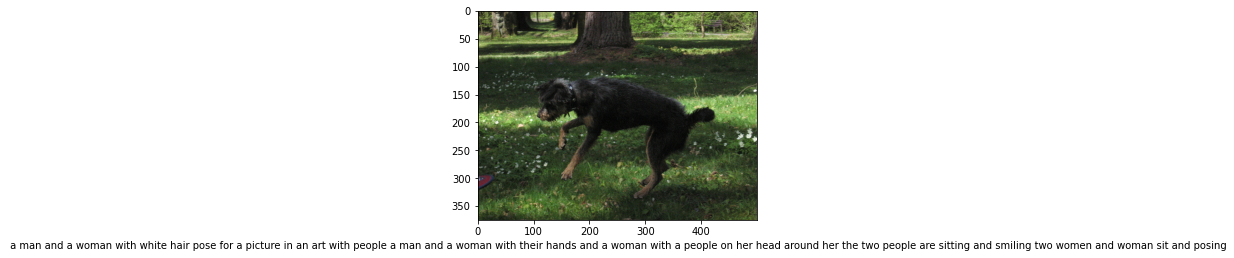

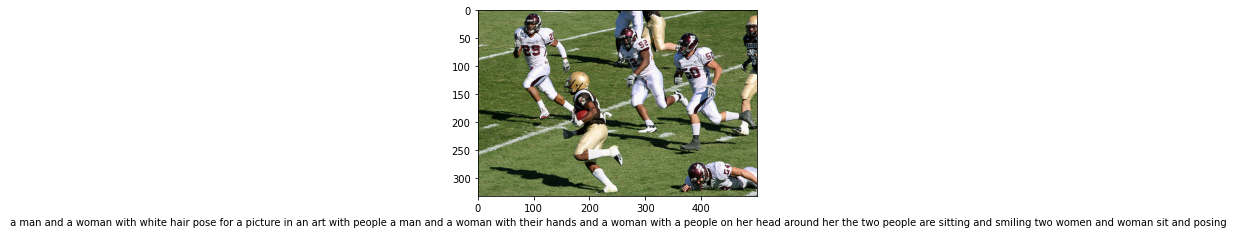

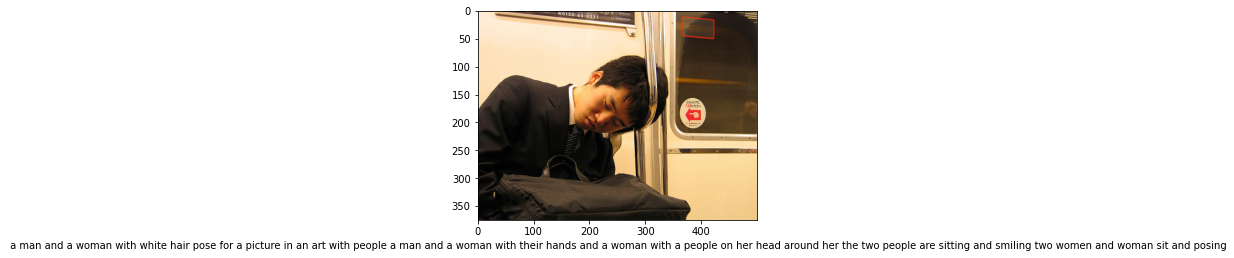

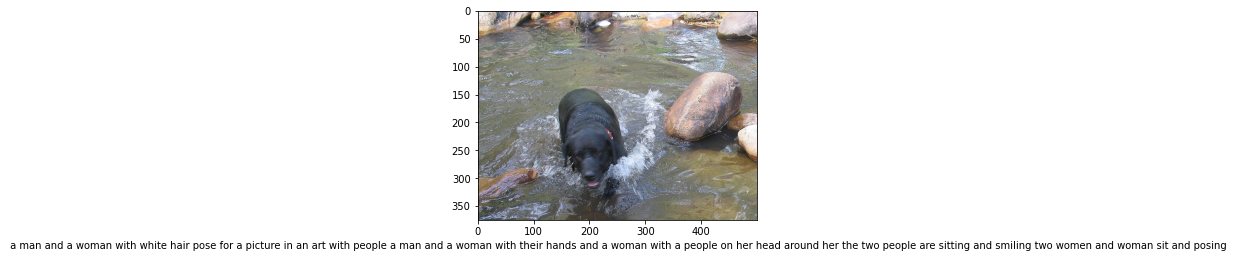

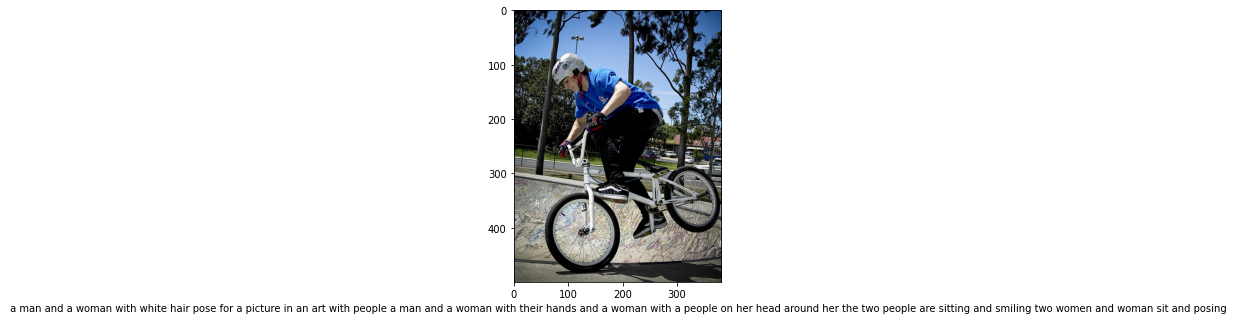

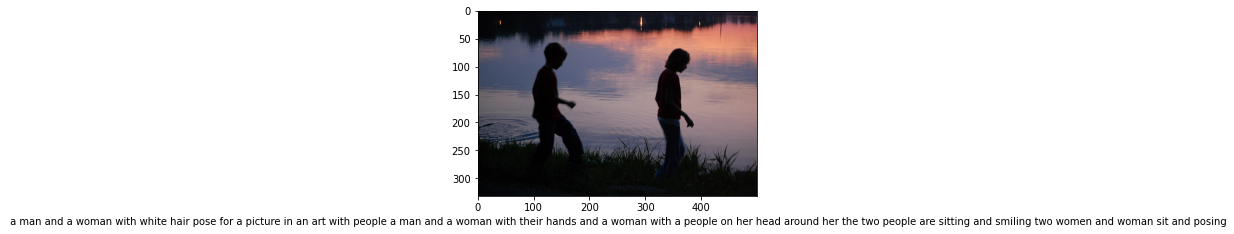

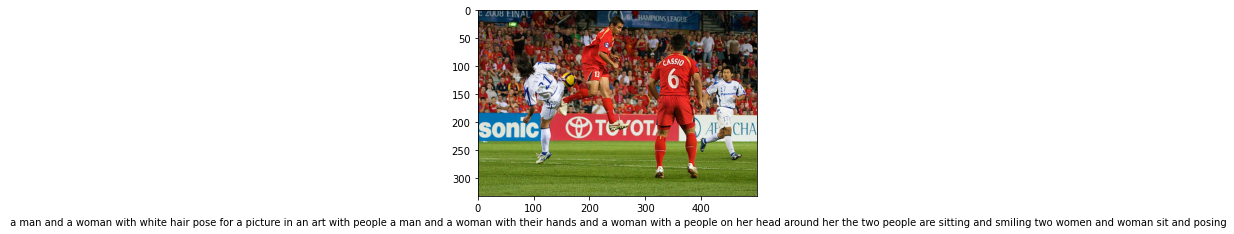

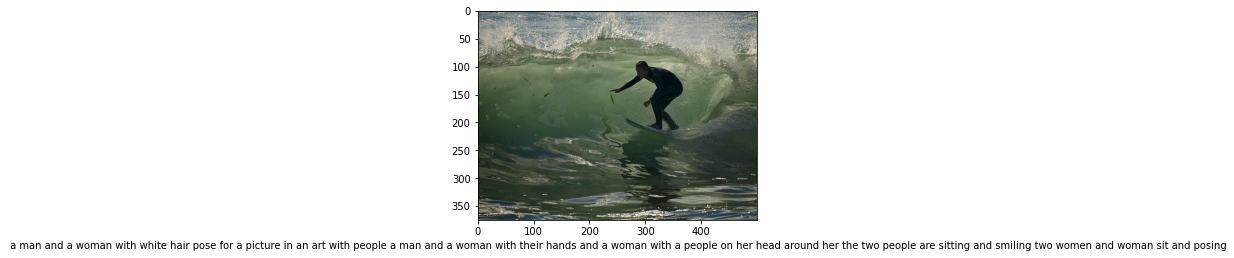

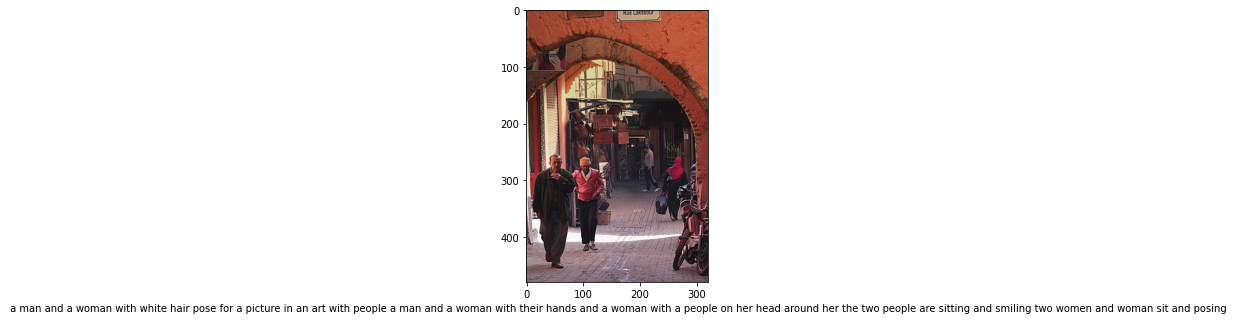

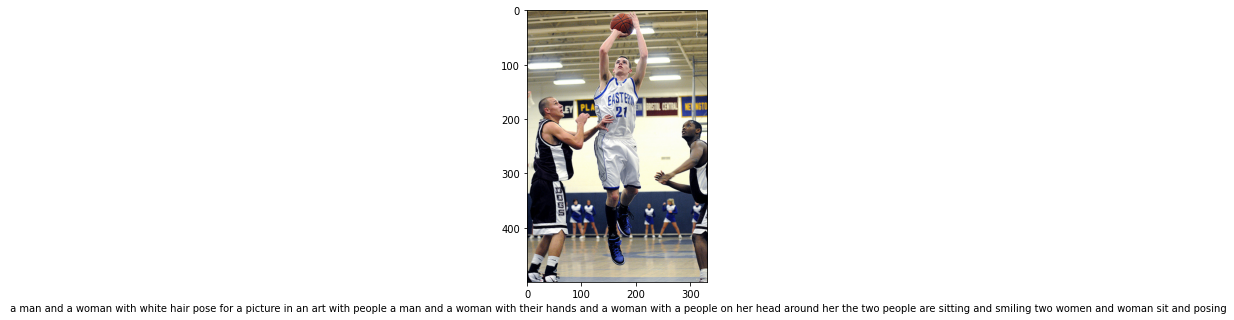

In [47]:
# predictions
for i in range(10):
    random_image = np.random.randint(0, len(images_paths), (1, 1))[0, 0]
    caption = generate_caption(rnn_model, images_paths, random_image)
